In [1]:
from __future__ import division


import numpy as np
import pandas as pd


import itertools
import math

import matplotlib.pyplot as plt
from random import randint
from matplotlib import style
import seaborn as sns

from sklearn import metrics

In [2]:
import acquire_log as aq

In [3]:
df = aq.get_log_data()

In [4]:
df.head()

,ip,timestamp,req,status,size,dash3,usr_agnt
0,97.105.19.58,2019-04-16 19:34:42,"""GET/api/v1/sales?page=81HTTP/1.1""",200,512495,"""-""","""python-requests/2.21.0"""
1,97.105.19.58,2019-04-16 19:34:42,"""GET/api/v1/itemsHTTP/1.1""",200,3561,"""-""","""python-requests/2.21.0"""
2,97.105.19.58,2019-04-16 19:34:44,"""GET/api/v1/sales?page=82HTTP/1.1""",200,510103,"""-""","""python-requests/2.21.0"""
3,97.105.19.58,2019-04-16 19:34:46,"""GET/api/v1/sales?page=83HTTP/1.1""",200,510003,"""-""","""python-requests/2.21.0"""
4,97.105.19.58,2019-04-16 19:34:48,"""GET/api/v1/sales?page=84HTTP/1.1""",200,511963,"""-""","""python-requests/2.21.0"""


In [5]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [6]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [7]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [8]:
df.head(1)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""


In [9]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [10]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [11]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [12]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 7 columns):
ip                13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
size_mb           13978 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 873.6+ KB


In [14]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1
GET /api/v1/items/HTTP/1.1                          1
GET /api/v1//api/v1/items/next_page HTTP/1.1        1
GET /api/v1/helloclass! HTTP

In [15]:
df.status.value_counts()

200    13960
499       16
301        2
Name: status, dtype: int64

In [16]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
3.88.129.158          1
35.174.209.2          1
34.229.70.250         1
3.92.201.136          1
45.23.250.16          1
52.91.30.150          1
95.31.18.119          1
52.90.165.200         1
97.105.15.120         1
95.31.16.121          1
34.207.64.242         1
54.145.52.184         1
54.172.14.223         1
Name: ip, dtype: int64

In [17]:
df.request_agent.value_counts()

python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

## Detecting anomalies in already existing data by proportion: (using request agent)

In [18]:
ra_df = pd.DataFrame(df['request_agent'].value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_count'})
ra_df2 = pd.DataFrame(df['request_agent'].value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_proba'})
ra_df = ra_df.merge(ra_df2)

In [19]:
ra_df

,request_agent,agent_count,agent_proba
0,python-requests/2.21.0,12005,0.858850
1,python-requests/2.20.1,1911,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


In [20]:
ra_df[ra_df.agent_proba < .01]

,request_agent,agent_count,agent_proba
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


In [21]:
print('Number of request agents: {}'.format(len(ra_df)))

print(ra_df.tail(7))

Number of request agents: 9
                                       request_agent  agent_count  agent_proba
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...           34     0.002432
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...            8     0.000572
4  Slackbot-LinkExpanding 1.0 (+https://api.slack...            7     0.000501
5       Slackbot 1.0 (+https://api.slack.com/robots)            6     0.000429
6  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...            4     0.000286
7  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...            2     0.000143
8                                  Python-urllib/3.7            1     0.000072


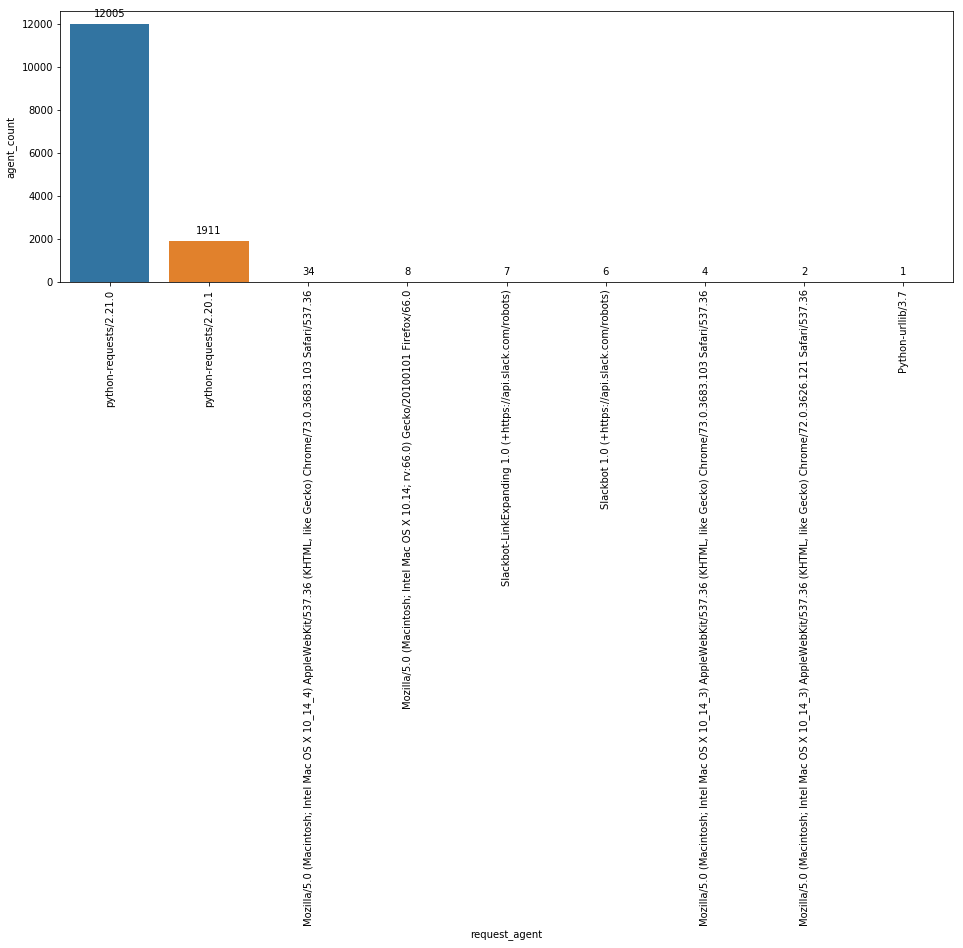

In [22]:
plt.figure(figsize=(16, 5))
splot = sns.barplot(data=ra_df, x = 'request_agent', y = 'agent_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Detecting anomalies by establishing a baseline and evaluate as new data arrives (using request agent)

In [23]:
train = df['2019-04-16 19:34:42':'2019-04-16 21:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

In [24]:
train.head(2)

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396


In [25]:
ra_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'agent_proba'})

In [26]:
ra_df

,request_agent,agent_proba
0,python-requests/2.21.0,0.805716
1,python-requests/2.20.1,0.190301
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002589
3,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000597
4,Slackbot 1.0 (+https://api.slack.com/robots),0.000498
5,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000199
6,Python-urllib/3.7,0.000100


In [27]:
df = df.reset_index().merge(ra_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')
df.agent_proba.value_counts()

0.805716    12005
0.190301     1911
0.002589       34
0.000000       10
0.000597        7
0.000498        6
0.000199        4
0.000100        1
Name: agent_proba, dtype: int64

## Conditional Probabilities: probabilities using 2 discrete variables (request agent, ip)


In [28]:
ra_probs = train.groupby('request_agent').size().div(len(df))


In [29]:
ra_probs

request_agent
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.000143
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.001860
Python-urllib/3.7                                                                                                            0.000072
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                 0.000358
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                   0.000429
python-requests/2.20.1                                                                                                       0.136715
python-requests/2.21.0                                                                                                       0.578838
dtype: float64

In [30]:
ip_given_agent = pd.DataFrame(train.groupby(['request_agent', 'ip']).\
                               size().div(len(train)).\
                               div(ra_probs, 
                                   axis=0, 
                                   level='request_agent').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_ip_given_agent'})
                              )

In [31]:
ip_given_agent

,request_agent,ip,proba_ip_given_agent
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,97.105.19.58,1.391954
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,97.105.19.58,1.391954
2,Python-urllib/3.7,97.105.19.58,1.391954
3,Slackbot 1.0 (+https://api.slack.com/robots),34.207.64.242,0.278391
4,Slackbot 1.0 (+https://api.slack.com/robots),34.229.70.250,0.278391
5,Slackbot 1.0 (+https://api.slack.com/robots),35.174.209.2,0.278391
6,Slackbot 1.0 (+https://api.slack.com/robots),52.90.165.200,0.278391
7,Slackbot 1.0 (+https://api.slack.com/robots),54.145.52.184,0.278391
8,Slackbot-LinkExpanding 1.0 (+https://api.slack...,3.88.129.158,0.231992
9,Slackbot-LinkExpanding 1.0 (+https://api.slack...,3.92.201.136,0.231992


In [32]:
agent_ip_count = pd.DataFrame(train.groupby(['request_agent', 'ip'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'agent_ip_count'}))

agent_status = ip_given_agent.merge(agent_ip_count)


In [33]:
agent_ip_count

,request_agent,ip,agent_ip_count
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,97.105.19.58,2
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,97.105.19.58,26
2,Python-urllib/3.7,97.105.19.58,1
3,Slackbot 1.0 (+https://api.slack.com/robots),34.207.64.242,1
4,Slackbot 1.0 (+https://api.slack.com/robots),34.229.70.250,1
5,Slackbot 1.0 (+https://api.slack.com/robots),35.174.209.2,1
6,Slackbot 1.0 (+https://api.slack.com/robots),52.90.165.200,1
7,Slackbot 1.0 (+https://api.slack.com/robots),54.145.52.184,1
8,Slackbot-LinkExpanding 1.0 (+https://api.slack...,3.88.129.158,1
9,Slackbot-LinkExpanding 1.0 (+https://api.slack...,3.92.201.136,1


In [34]:
df = df.reset_index().merge(agent_status, on=['request_agent', 'ip'], how='left').fillna(value=0).set_index('timestamp')

In [35]:
df

,ip,request_method,status,size,destination,request_agent,size_mb,agent_proba,proba_ip_given_agent,agent_ip_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.805716,1.391954,8091.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.805716,1.391954,8091.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.805716,1.391954,8091.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.805716,1.391954,8091.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.805716,1.391954,8091.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/stores HTTP/1.1,200,1328,0,python-requests/2.21.0,0.001266,0.805716,1.391954,8091.0
2019-04-16 19:34:50,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510753,0,python-requests/2.21.0,0.487092,0.805716,1.391954,8091.0
2019-04-16 19:34:52,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510348,0,python-requests/2.21.0,0.486706,0.805716,1.391954,8091.0
2019-04-16 19:34:52,97.105.19.58,GET / HTTP/1.1,200,42,0,python-requests/2.21.0,0.000040,0.805716,1.391954,8091.0


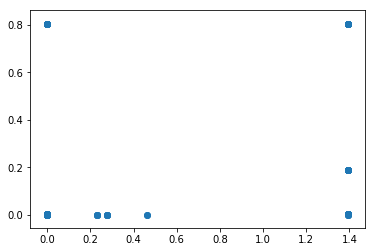

In [36]:
plt.scatter(df.proba_ip_given_agent, df.agent_proba)

In [37]:
df.size_mb.value_counts(bins=10)

(0.392, 0.588]       12318
(-0.00296, 0.196]     1588
(0.196, 0.392]          70
(1.765, 1.961]           1
(0.981, 1.177]           1
(1.569, 1.765]           0
(1.373, 1.569]           0
(1.177, 1.373]           0
(0.784, 0.981]           0
(0.588, 0.784]           0
Name: size_mb, dtype: int64

# ~~~~~~Exercise Two ~~~~~~~

In [38]:
# some functions to get the data from the access log:
def read_log_cr():
    with open('anonymized-curriculum-access.txt') as f:
        lines = f.read()
        return lines
def split_content(lines):
    lines = lines.split('\n')
    return lines

def split_lines(lines):
    new_lines = []
    for line in lines:
        new_lines.append(line.split(' '))
    return new_lines

In [39]:
# use first function
lines = read_log_cr()

In [40]:
# use second function, split lines
lines = split_content(lines)

In [41]:
# split again
lines = split_lines(lines)

In [42]:
# join date and time
for i, elmnt in enumerate(lines):
    elmnt[0:2] = [' '.join(elmnt[0:2])]

In [43]:
# investigate to see if format is clean for rows
lines[0]

['2018-01-26 09:55:03', '/', '1', '8', '97.105.19.61']

In [44]:
# turn into pandas dataframe
dfc =pd.DataFrame(lines, columns=['timestamp','page','student','cohort','ip'])

In [45]:
dfc.head()

,timestamp,page,student,cohort,ip
0,2018-01-26 09:55:03,/,1,8,97.105.19.61
1,2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


In [46]:
# convert timestamp to datetime format
dfc.timestamp = pd.to_datetime(dfc.timestamp)

In [47]:
# check out frame, parse for null values
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233529 entries, 0 to 233528
Data columns (total 5 columns):
timestamp    233528 non-null datetime64[ns]
page         233528 non-null object
student      233528 non-null object
cohort       233528 non-null object
ip           233528 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 8.9+ MB


In [48]:
# set index to datetime
dfc = dfc.set_index('timestamp')

In [49]:
# pick a single cohort and run the time series analysis on that.

In [50]:
#drop last row that appears to be trash data/error
dfc.drop(dfc.tail(1).index,inplace=True)

In [51]:
#after much hardship, this method works to replace the non-na NaNs in cohort.

In [52]:
dfc['cohort'] = pd.to_numeric(dfc['cohort'], errors='coerce')

dfc['cohort'] = dfc['cohort'].replace(np.nan, 0)

dfc['cohort'] = dfc.cohort.astype(int)

In [53]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 233528 entries, 2018-01-26 09:55:03 to 2019-04-02 11:11:29
Data columns (total 4 columns):
page       233528 non-null object
student    233528 non-null object
cohort     233528 non-null int64
ip         233528 non-null object
dtypes: int64(1), object(3)
memory usage: 8.9+ MB


In [54]:
dfc.cohort.value_counts()

24    34485
22    28268
23    26655
25    24681
26    24088
29    20471
27    19255
0     14458
1      8821
14     6523
21     6465
28     6163
31     2997
13     2163
17     1805
8      1671
18     1482
19      901
16      740
15      632
7       338
12      230
2        89
11       79
6        59
9         5
4         4
Name: cohort, dtype: int64

In [55]:
dfc.head()

,page,student,cohort,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


In [56]:
df_tmp = dfc.groupby(['cohort','student']).resample('W').count()
df_tmp = df_tmp[['page']]
df_tmp = df_tmp.reset_index(level=[1])
df_tmp[df_tmp.index == 1].groupby('student', as_index=False).mean()

,student,page


## break

In [57]:
# dataframe resampled by day for student count in cohort 21
df_access = dfc[dfc.cohort == 21]['student'].resample('D').nunique()
dfc[dfc.cohort == 21].student.value_counts()

10     732
153    718
41     609
110    510
27     482
38     370
15     288
28     279
36     243
52     234
42     199
22     199
16     190
47     183
57     182
17     175
56     170
33     151
255    114
65     106
175    102
55      95
45      65
24      26
49      25
286     12
115      6
Name: student, dtype: int64

In [58]:
idx = pd.date_range(
    df_access.sort_index().index.min(), 
    df_access.sort_index().index.max(),
    freq='D'
)

df_access = df_access.reindex(idx, fill_value=1).fillna(value=1)

In [59]:
df_access.head()

2018-01-26    16
2018-01-27     9
2018-01-28     6
2018-01-29    20
2018-01-30    16
Freq: D, Name: student, dtype: int64

In [60]:
# df_access.tail()
df_access.head(1).index[0]

Timestamp('2018-01-26 00:00:00', freq='D')

In [61]:
start_date_train = df_access.head(1).index[0]
end_date_train = '2018-06-29'
start_date_test = '2018-06-30'

train = df_access[:end_date_train]
test = df_access[start_date_test:]

In [62]:
train.head()

2018-01-26    16
2018-01-27     9
2018-01-28     6
2018-01-29    20
2018-01-30    16
Freq: D, Name: student, dtype: int64

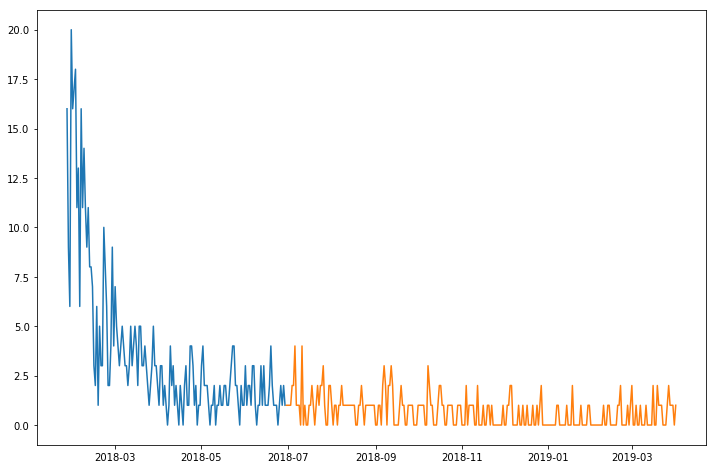

In [63]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

rolling mean test:

In [64]:
dfc.groupby('student').count()


,page,cohort,ip
student,,,
1,2639,2639,2639
10,732,732,732
100,59,59,59
101,203,203,203
102,80,80,80
103,42,42,42
104,8,8,8
105,227,227,227
106,102,102,102


In [65]:
short_rolling = train.rolling(window=30).mean()

long_rolling = train.rolling(window=60).mean()

Text(0, 0.5, 'students')

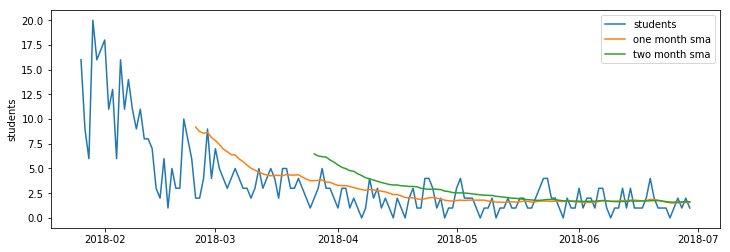

In [66]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='students')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = 'one month sma')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = 'two month sma')

ax.legend(loc='best')
ax.set_ylabel('students')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

In [67]:
ema_short = train.ewm(span=30, adjust=False).mean()
ema_long = train.ewm(span=60, adjust=False).mean()

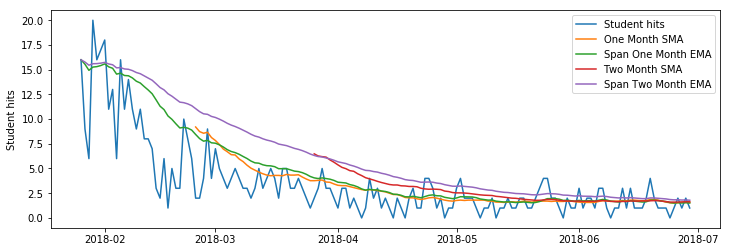

In [68]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Student hits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = 'One Month SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span One Month EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = 'Two Month SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span Two Month EMA')

ax.legend(loc='best')
ax.set_ylabel('Student hits')

yhat = pd.DataFrame(dict(actual=test))

In [69]:
# yhat['moving_avg_forecast'] = ema_long.iloc[-1]

In [70]:
# span = 24
# ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3
yhat['moving_avg_forecast'] = midband

In [71]:
yhat['moving_avg_forecast'] = ema_long.iloc[-1]

yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

q3 = yhat.error.describe().loc['75%']
q1 = yhat.error.describe().loc['25%']

In [72]:
yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [73]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2018-07-06,4,1.788687,2.211313,3.801920
2018-07-11,4,1.788687,2.211313,3.801920
2018-07-26,3,1.788687,1.211313,2.308726
2018-09-07,3,1.788687,1.211313,2.308726
2018-09-12,3,1.788687,1.211313,2.308726
2018-10-08,3,1.788687,1.211313,2.308726


In [74]:
def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    
    
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

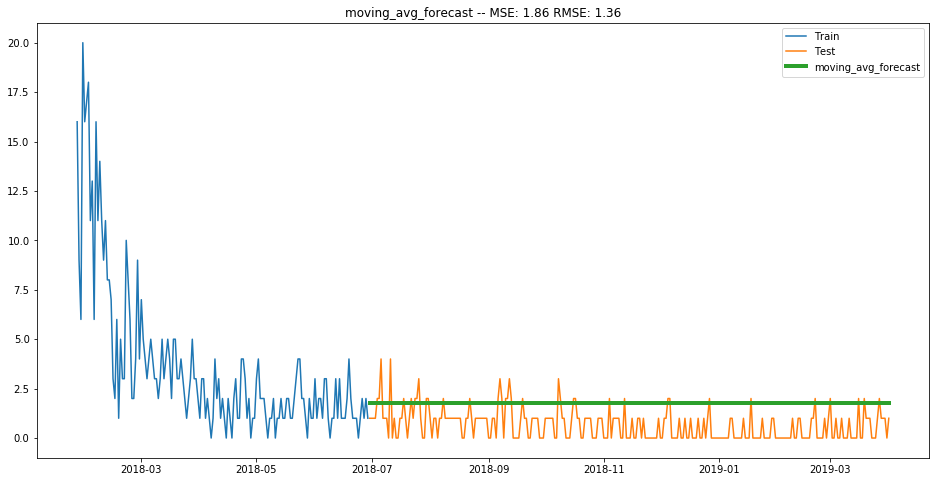

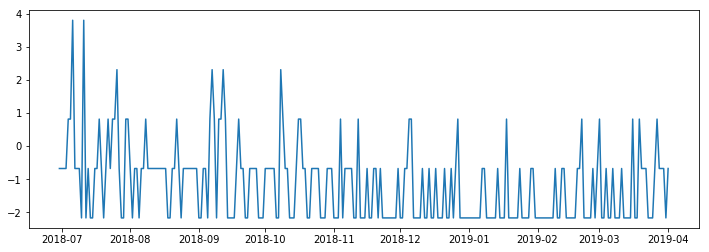

In [75]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

## impute end_dates

to attempt to identify specific students that have viewed curriculum past program dates, let's attempt to identify end dates of programs by cohorts and locate students that have viewed curriculum after end dates.

In [76]:
cohort_names = pd.read_csv('cohort_name_to_id.csv')

In [77]:
cohort_dates = pd.read_csv('cohort_dates.csv', sep='\n')

In [78]:
cohort_dates.head()

,{\rtf1\ansi\ansicpg1252\cocoartf1671\cocoasubrtf400
0,{\fonttbl\f0\fswiss\fcharset0 Helvetica;}
1,{\colortbl;\red255\green255\blue255;}
2,{\*\expandedcolortbl;;}
3,\margl1440\margr1440\vieww10800\viewh8400\view...
4,\pard\tx720\tx1440\tx2160\tx2880\tx3600\tx4320...


id,name,start_date,end_date
1,Arches,2014-02-04,2014-04-22
2,Badlands,2014-06-04,2014-08-22
3,Carlsbad,2014-09-04,2014-11-05
4,Denali,2014-10-20,2015-01-18
5,Everglades,2014-11-18,2015-02-24
6,Franklin,2015-02-03,2015-05-26
7,Glacier,2015-06-05,2015-10-06
8,Hampton,2015-09-22,2016-02-06
9,Apollo,2015-03-30,2015-07-29
10,Balboa,2015-11-03,2016-03-11
11,Ike,2016-01-20,2016-05-12
12,Joshua,2016-03-08,2016-06-30
13,Kings,2016-05-23,2016-09-15
14,Lassen,2016-07-18,2016-11-10
15,Mammoth,2016-09-26,2017-02-02
16,Niagara,2016-10-26,2017-03-09
17,Olympic,2017-02-06,2017-05-25
18,Pinnacles,2017-03-27,2017-07-20
19,Quincy,2017-06-05,2017-09-22
20,Redwood,2017-07-31,2017-12-06
21,Sequoia,2017-09-27,2018-02-15
22,Teddy,2018-01-08,2018-05-17
23,Ulysses,2018-03-05,2018-07-19
24,Voyageurs,2018-05-29,2018-10-11
25,Wrangell,2018-07-23,2018-11-29
26,Xanadu,2018-09-17,2019-02-08
27,Yosemite,2018-11-05,2019-04-03
28,Staff,2014-02-04,2014-02-04
29,Zion,2019-01-22,2019-06-04
30,Ada,2019-02-04,2019-06-16
31,Andromeda,2019-03-18,2019-07-30

In [79]:
cohort_dates=pd.read_clipboard(sep=',')

In [80]:
dfc.head()

,page,student,cohort,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


In [81]:
cohort_names.rename(columns={'id ': 'cohort_id'}, inplace=True)
dfc.rename(columns={'cohort': 'cohort_id'}, inplace=True)

In [82]:
dfc = dfc.reset_index().merge(cohort_names, on='cohort_id', how='left')

In [83]:
dfc.head()

,timestamp,page,student,cohort_id,ip,name
0,2018-01-26 09:55:03,/,1,8,97.105.19.61,Hampton
1,2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton
3,2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton
4,2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy


In [84]:
cohort_dates.head()

,id,name,start_date,end_date
0,1,Arches,2014-02-04,2014-04-22
1,2,Badlands,2014-06-04,2014-08-22
2,3,Carlsbad,2014-09-04,2014-11-05
3,4,Denali,2014-10-20,2015-01-18
4,5,Everglades,2014-11-18,2015-02-24


In [85]:
cohort_dates = cohort_dates[['name', 'start_date', 'end_date']]
dfc = dfc.merge(cohort_dates, on='name', how='left')

In [86]:
dfc.head()

,timestamp,page,student,cohort_id,ip,name,start_date,end_date
0,2018-01-26 09:55:03,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
1,2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
3,2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
4,2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17


In [88]:
dfc['timestamp'] = pd.to_datetime(dfc['timestamp'])

In [89]:
dfc['start_date'] = pd.to_datetime(dfc['start_date'])
dfc['end_date'] = pd.to_datetime(dfc['end_date'])

In [90]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233528 entries, 0 to 233527
Data columns (total 8 columns):
timestamp     233528 non-null datetime64[ns]
page          233528 non-null object
student       233528 non-null object
cohort_id     233528 non-null int64
ip            233528 non-null object
name          219070 non-null object
start_date    219070 non-null datetime64[ns]
end_date      219070 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(4)
memory usage: 16.0+ MB


In [92]:
dfc['visit_after_course'] = [lambda x: x = 1 if dfc.timestamp > dfc.end_date]

SyntaxError: invalid syntax (<ipython-input-92-627519c46932>, line 1)